In [129]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
import lightgbm as lgb
from sklearn.model_selection import KFold
import time
from datetime import datetime

In [5]:
col_select = ['device','geoNetwork','totals','trafficSource']

In [6]:
df_raw = pd.read_csv('/Users/liaopeng3/logs/google_analytics_all/train.csv',\
                  converters={cols:json.loads for cols in col_select},dtype={'fullVisitorId': 'str'},header=0)

In [8]:
for cols in col_select:
    column_as_df = json_normalize(df_raw[cols])
    column_as_df.columns = [f"{cols}.{subcolumn}" for subcolumn in column_as_df.columns]
    df_raw = df_raw.drop(cols,axis=1)
    df_raw = df_raw.merge(column_as_df,left_index=True,right_index=True)

In [230]:
df_raw['totals.transactionRevenue'].head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: totals.transactionRevenue, dtype: object

In [236]:
df3 = df_raw.copy()

In [237]:
# df3.head()

In [238]:
# df3['date'].value_counts()

In [239]:
# df3.dtypes

# Split Feature and Label Data

In [240]:
train_y = df3['totals.transactionRevenue'].fillna(0).astype(float).apply(lambda x: np.log1p(x))


In [241]:
train_y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: totals.transactionRevenue, dtype: float64

# Add Visit Time

In [242]:
df3['diff_visitId_time'] = df3['visitId'] - df3['visitStartTime']
df3['diff_visitId_time'] = (df3['diff_visitId_time'] != 0).astype(int)

In [243]:
df3.loc[1:5,['diff_visitId_time','visitId','visitStartTime']]

,diff_visitId_time,visitId,visitStartTime
1,0,1472880147,1472880147
2,0,1472865386,1472865386
3,0,1472881213,1472881213
4,0,1472822600,1472822600
5,0,1472807194,1472807194


In [244]:
df3['diff_visitId_time'].value_counts()

0    898944
1      4709
Name: diff_visitId_time, dtype: int64

# Format the Numerous Variables

In [245]:
list_v = ['totals.hits','totals.pageviews','trafficSource.adwordsClickInfo.page']

In [246]:
for cols in list_v:
    df3[cols]=df3[cols].astype(float)

In [247]:
df3.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

In [248]:
df3.dtypes

channelGrouping                                       object
date                                                   int64
fullVisitorId                                         object
sessionId                                             object
socialEngagementType                                  object
visitId                                                int64
visitNumber                                            int64
visitStartTime                                         int64
device.browser                                        object
device.browserSize                                    object
device.browserVersion                                 object
device.deviceCategory                                 object
device.flashVersion                                   object
device.isMobile                                         bool
device.language                                       object
device.mobileDeviceBranding                           object
device.mobileDeviceInfo 

In [249]:
df3.loc[1020:1025,['visitId','fullVisitorId']]

,visitId,fullVisitorId
1020,1472853233,6712520540378436905
1021,1472880837,4111636069257027886
1022,1472828860,3152246617474456269
1023,1472824904,1856749147915772585
1024,1472822104,0343138238061206334
1025,1472840887,0026203741366904270


# Fill Null Cells with Most Frequent Value

In [250]:
# for cols in df3.columns:
#     if df3[cols].isna().sum()>0:
#         val_tmp = df3[cols].mode()[0]
#         df3[cols]=df3[cols].fillna(value=val_tmp)
    

##  Drop the Constant Columns

In [251]:
cols_drop = []
for cols in df3.columns:
    if df3[cols].nunique()==1:
        print(cols)
        cols_drop.append(cols)
        
df3 = df3.drop(cols_drop,axis=1)

socialEngagementType
device.browserSize
device.browserVersion
device.flashVersion
device.language
device.mobileDeviceBranding
device.mobileDeviceInfo
device.mobileDeviceMarketingName
device.mobileDeviceModel
device.mobileInputSelector
device.operatingSystemVersion
device.screenColors
device.screenResolution
geoNetwork.cityId
geoNetwork.latitude
geoNetwork.longitude
geoNetwork.networkLocation
totals.bounces
totals.newVisits
totals.visits
trafficSource.adwordsClickInfo.criteriaParameters
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.campaignCode
trafficSource.isTrueDirect


# Convert the Object Values to Numeric

In [252]:
for cols in df3.columns:
    if df3[cols].dtypes == object or df3[cols].dtypes== bool:
#         df3[cols] = df3[cols].astype('category')
#         df3["new_"+cols] = df3[cols].cat.codes
        df3["new_"+cols] = pd.factorize( df3[cols])[0]
        df3 = df3.drop(cols,axis=1)
        df3 = df3.rename(columns={"new_"+cols:cols})

# Convert Date to Numeric Variables

In [253]:
df3.head()

,date,visitId,visitNumber,visitStartTime,totals.hits,totals.pageviews,trafficSource.adwordsClickInfo.page,diff_visitId_time,channelGrouping,fullVisitorId,...,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,20160902,1472830385,1,1472830385,1.0,1.0,NaN,0,0,0,...,-1,-1,-1,-1,-1,0,0,0,-1,0
1,20160902,1472880147,1,1472880147,1.0,1.0,NaN,0,0,1,...,-1,-1,-1,-1,-1,0,0,0,-1,0
2,20160902,1472865386,1,1472865386,1.0,1.0,NaN,0,0,2,...,-1,-1,-1,-1,-1,0,0,0,-1,0
3,20160902,1472881213,1,1472881213,1.0,1.0,NaN,0,0,3,...,-1,-1,-1,-1,-1,0,1,0,-1,0
4,20160902,1472822600,2,1472822600,1.0,1.0,NaN,0,0,4,...,-1,-1,-1,-1,-1,0,0,0,-1,0


In [254]:
format_str = '%Y%m%d' 
df3['date'] = df3['date'].apply(lambda x: datetime.strptime(str(x), format_str))


In [255]:
df3['date_dayofweek'] = df3['date'].dt.dayofweek
df3['date_year'] = df3['date'].dt.year

df3['date_hour'] = df3['date'].dt.hour

df3['date_month'] = df3['date'].dt.month
df3['date_day'] = df3['date'].dt.day

df3['date_month'] = df3['date'].apply(lambda x:x.month)
df3['date_quarter_month'] = df3['date'].apply(lambda x:x.day//8)
df3['date_weekday'] = df3['date'].apply(lambda x:x.weekday())


In [256]:
# df3['date'].value_counts()

In [257]:
df3 = df3.drop('date',axis=1)

# Visit Time

In [258]:
df3['visitStartTime'] = df3['visitStartTime'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))

# df3['visitStartTime'] = pd.to_datetime(df3['visitStartTime'],unit='s')

In [259]:
# df3['visitStartTime'].value_counts()

In [260]:
df3['visitStartTime'] = pd.to_datetime(df3['visitStartTime'])

df3['quarter_month'] = df3['visitStartTime'].apply(lambda x:x.day//8)

# df3.loc[1020:1025,['visitStartTime','quarter_month']]

df3['quarter_month'].value_counts()

df3['day_month'] = df3['visitStartTime'].apply(lambda x:x.day)


# df3['day_month'].value_counts()

df3['WoY'] = df3['visitStartTime'].apply(lambda x: x.isocalendar()[1])

# df3['WoY'].value_counts()

df3['visit_dayofweek'] = df3['visitStartTime'].dt.dayofweek
df3['visit_year'] = df3['visitStartTime'].dt.year

df3['visit_month'] = df3['visitStartTime'].dt.month
df3['visit_day'] = df3['visitStartTime'].dt.day
df3['visit_hour'] = df3['visitStartTime'].dt.hour

df3 = df3.drop('visitStartTime',axis=1)

In [261]:
# df3 = df3.drop('formated_visitStartTime',axis=1)

# Clean the Data Again

##  Drop the Constant Columns

In [262]:
cols_drop = []
for cols in df3.columns:
    if df3[cols].nunique()==1:
        print(cols)
        cols_drop.append(cols)
        
df3 = df3.drop(cols_drop,axis=1)

date_hour


# Baseline Model

# Split Feature and Label Data

In [263]:
train_x = df3.drop(['totals.transactionRevenue','sessionId','visitId'],axis=1)


# Training Model

In [265]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(max_depth=2, random_state=0,
                             n_estimators=100)
# model=regr.fit(train_x, train_y)


In [266]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [267]:
from sklearn.metrics import mean_squared_error

In [268]:
import numpy as np

In [269]:
# calc_train_error(train_x, train_y, model)

In [270]:
param = {'num_leaves': 300,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 1,
         "verbosity": -1}

In [271]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(df3))
predictions = np.zeros(len(df3))
start = time.time()
features = list(train_x.columns)
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_x.values, train_y.values)):
    trn_data = lgb.Dataset(train_x.iloc[trn_idx].values, label=train_y.iloc[trn_idx].values)
    val_data = lgb.Dataset(train_x.iloc[val_idx].values, label=train_y.iloc[val_idx].values)
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train_x.iloc[val_idx].values, num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(train_x.values, num_iteration=clf.best_iteration) / folds.n_splits

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.57093	valid_1's rmse: 1.63733
Early stopping, best iteration is:
[84]	training's rmse: 1.56897	valid_1's rmse: 1.63631
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.56896	valid_1's rmse: 1.64207
Early stopping, best iteration is:
[84]	training's rmse: 1.56664	valid_1's rmse: 1.64115
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.56584	valid_1's rmse: 1.65037
Early stopping, best iteration is:
[84]	training's rmse: 1.56331	valid_1's rmse: 1.64904
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.56025	valid_1's rmse: 1.67709
Early stopping, best iteration is:
[84]	training's rmse: 1.5583	valid_1's rmse: 1.67533
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.56688	valid_1's rmse: 1.64452
Early stopping, best iteration is:
[84]	training's rmse

/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


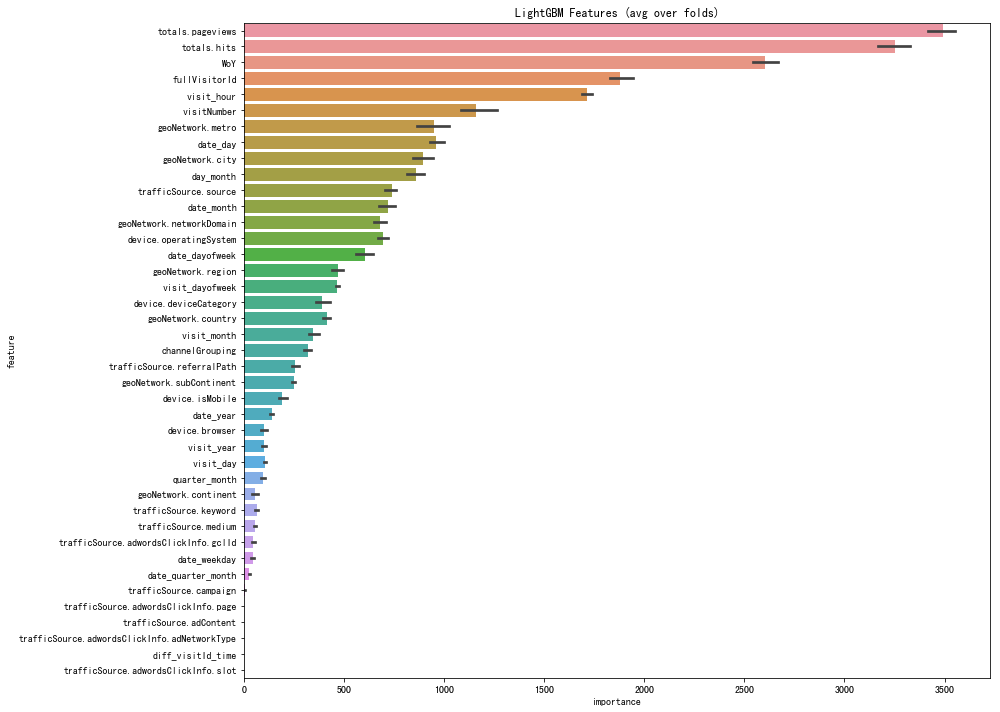

In [272]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:1000].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')